#Класифікація грибів за допомогою Inception

In [ ]:
import os
import shutil
import random
import numpy as np
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.applications import InceptionV3
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
import zipfile

# Розархівування набору даних
local_zip = './minerals.zip'  # Назва вашого архіву
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./base_minerals')  # Шлях для розархівованих даних
zip_ref.close()


In [ ]:
import os
import shutil
import random

# Шляхи до вихідного і цільового набору даних
original_dataset_dir = './base_minerals/minerals'
base_dir = 'minerals_gen'

# Створення папок для train, validation та test
os.makedirs(base_dir, exist_ok=True)
for split in ['train', 'validation', 'test']:
    split_dir = os.path.join(base_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    for class_name in os.listdir(original_dataset_dir):
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

# Функція для розподілу файлів по вибірках
def split_data(class_dir, train_dir, val_dir, test_dir):
    files = os.listdir(class_dir)

    train_split = int(len(files) * 0.8)
    val_split = int(len(files) * 0.9)

    train_files = files[:train_split]
    val_files = files[train_split:val_split]
    test_files = files[val_split:]

    for file in train_files:
        shutil.copy(os.path.join(class_dir, file), train_dir)
    for file in val_files:
        shutil.copy(os.path.join(class_dir, file), val_dir)
    for file in test_files:
        shutil.copy(os.path.join(class_dir, file), test_dir)

# Розподіл файлів для кожного класу
for class_name in os.listdir(original_dataset_dir):
    class_dir = os.path.join(original_dataset_dir, class_name)
    if os.path.isdir(class_dir):
        split_data(
            class_dir,
            os.path.join(base_dir, 'train', class_name),
            os.path.join(base_dir, 'validation', class_name),
            os.path.join(base_dir, 'test', class_name)
        )

print("Файли успішно розподілені на вибірки!")

Файли успішно розподілені на вибірки!


In [ ]:
#Підготовка генераторів даних
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=45, width_shift_range=0.3,
                                   height_shift_range=0.3, shear_range=0.3, zoom_range=0.3,
                                   horizontal_flip=True, fill_mode='nearest')

datagen = ImageDataGenerator(rescale=1.0/255)

img_width, img_height = 299, 299

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=16,
    class_mode='categorical'
)

Found 758 images belonging to 7 classes.
Found 190 images belonging to 7 classes.
Found 147 images belonging to 7 classes.


In [ ]:
# Шлях до директорії навчальних даних
train_dir = './minerals_gen/train'

# Визначення кількості класів
classes_num = len(os.listdir(train_dir))

# Завантаження базової моделі InceptionV3
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Розморожування базової частини моделі
conv_base.trainable = True

# Заморожуємо частину базових шарів (наприклад, перші 200 шарів)
for layer in conv_base.layers[:200]:
    layer.trainable = False


# Побудова моделі
x = layers.GlobalAveragePooling2D()(conv_base.output)
x = layers.Dense(1024, activation='relu')(x)  # Додатковий повнозв'язний шар
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(classes_num, activation='softmax')(x)

model = Model(inputs=conv_base.input, outputs=x)

# Компіляція моделі з новими налаштуваннями
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Навчання моделі з частково розмороженою базовою частиною
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

model.save('minerals_classification_EXP4.h5')

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 359s 7s/step - accuracy: 0.8170 - loss: 0.5482 - val_accuracy: 0.7579 - val_loss: 1.8036
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 356s 7s/step - accuracy: 0.7981 - loss: 0.5856 - val_accuracy: 0.8053 - val_loss: 0.9970
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 384s 7s/step - accuracy: 0.8686 - loss: 0.4227 - val_accuracy: 0.6947 - val_loss: 2.2717
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 381s 7s/step - accuracy: 0.8683 - loss: 0.3807 - val_accuracy: 0.7368 - val_loss: 1.5309
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 380s 7s/step - accuracy: 0.8571 - loss: 0.4780 - val_accuracy: 0.8632 - val_loss: 0.6013
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 418s 8s/step - accuracy: 0.9131 - loss: 0.2813 - val_accuracy: 0.8316 - val_loss: 0.7427
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 394s 8s/step - accuracy: 0.8690 - loss: 0.3874 - val_accuracy: 0.8526 - val_loss: 0.5069
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 403s 7s/step - accuracy: 0.8346 - loss: 0.4356 - val_accuracy: 0.9000 - v

In [ ]:
# Оцінка моделі на тестових даних
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Тестова втрата: {test_loss:.4f}")
print(f"Тестова точність: {test_accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.8225 - loss: 0.6785
Тестова втрата: 0.7573
Тестова точність: 0.8194


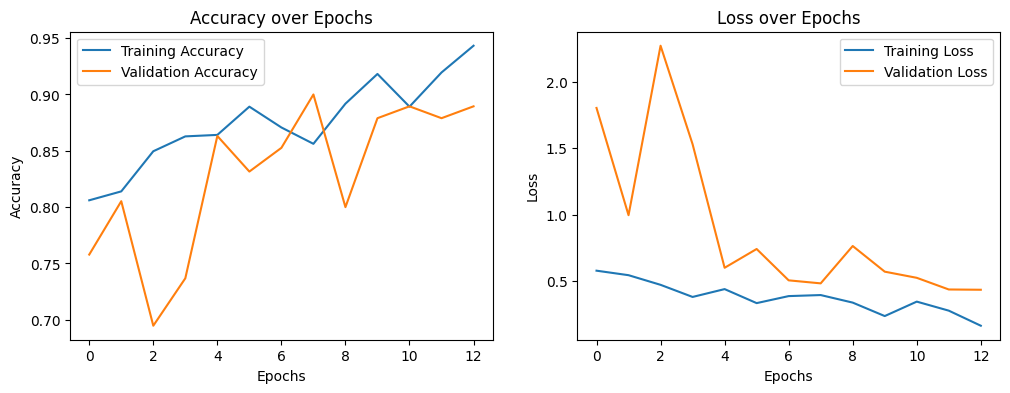

In [ ]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()